# DBSCAN: Density-Based Clustering and Anomaly Detection in Python

Discover how DBSCAN (Density-Based Spatial Clustering of Applications with Noise) revolutionizes clustering by finding arbitrarily shaped clusters and automatically identifying outliers. This comprehensive guide covers everything from theory to practical implementation.

## What is DBSCAN?

DBSCAN is a density-based clustering algorithm that groups together points that are closely packed and marks points in low-density regions as outliers. Unlike k-means, DBSCAN:
- **Doesn't require specifying the number of clusters**
- **Finds clusters of arbitrary shapes**
- **Automatically identifies noise points (anomalies)**
- **Robust to outliers**

### Why DBSCAN Matters

Traditional clustering algorithms like k-means struggle with:
- Non-spherical cluster shapes
- Clusters of varying densities
- Presence of noise and outliers

DBSCAN excels in all these scenarios, making it invaluable for:
- Anomaly detection in network traffic
- Geospatial data analysis
- Customer segmentation with outliers
- Image segmentation
- Fraud detection

## Core Concepts

### Key Parameters

**1. eps (ε)**: The maximum distance between two points to be considered neighbors
- Smaller eps = tighter clusters, more noise
- Larger eps = looser clusters, fewer noise points

**2. min_samples**: Minimum number of points needed to form a dense region (cluster)
- Higher values = denser clusters required
- Lower values = easier to form clusters

### Point Classifications

DBSCAN classifies each point into one of three categories:

1. **Core Points**: Have at least `min_samples` points within distance `eps`
2. **Border Points**: Within `eps` of a core point but have fewer than `min_samples` neighbors
3. **Noise Points**: Neither core nor border points (these are your anomalies!)

### Visual Illustration

```
eps radius →  ●────○
              │
    Core →    ●  ←  ○  ← Border
              │
              ●────○

    Noise →   ×  (isolated point)
```


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
np.random.seed(42)

In [2]:
# Generate sample data with noise
X, _ = make_moons(n_samples=300, noise=0.05, random_state=42)

# Add some outliers
outliers = np.random.uniform(low=-2, high=3, size=(20, 2))
X = np.vstack([X, outliers])

print(f"Dataset size: {len(X)} points")

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# Analyze results
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"\nDBSCAN Results:")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Cluster labels: {set(labels)}")

Dataset size: 320 points

DBSCAN Results:
Number of clusters: 2
Number of noise points: 18
Cluster labels: {np.int64(0), np.int64(1), np.int64(-1)}


In [ ]:
Visualize the Results


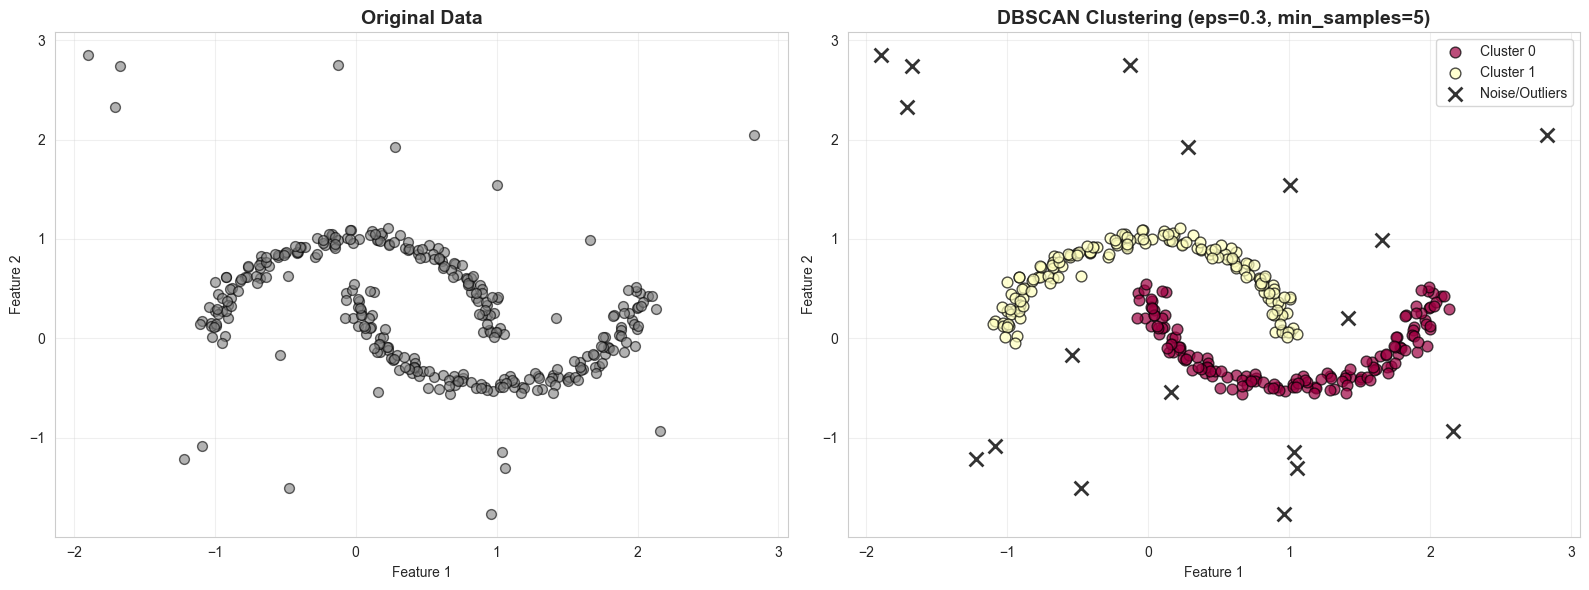

In [3]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Original data
ax1 = axes[0]
ax1.scatter(X[:, 0], X[:, 1], c='gray', s=50, alpha=0.6, edgecolors='k')
ax1.set_title('Original Data', fontsize=14, fontweight='bold')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.grid(True, alpha=0.3)

# Plot 2: DBSCAN clustering
ax2 = axes[1]

# Plot clusters with different colors
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Noise points in black
        class_member_mask = (labels == label)
        xy = X[class_member_mask]
        ax2.scatter(xy[:, 0], xy[:, 1], c='black', s=100, alpha=0.8,
                   marker='x', linewidths=2, label='Noise/Outliers')
    else:
        # Cluster points
        class_member_mask = (labels == label)
        xy = X[class_member_mask]
        ax2.scatter(xy[:, 0], xy[:, 1], c=[color], s=60, alpha=0.7,
                   edgecolors='k', label=f'Cluster {label}')

ax2.set_title(f'DBSCAN Clustering (eps={dbscan.eps}, min_samples={dbscan.min_samples})',
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Finding Optimal Parameters
Method 1: k-Distance Graph (for eps)
The k-distance graph helps determine the optimal eps value by plotting distances to the k-th nearest neighbor.

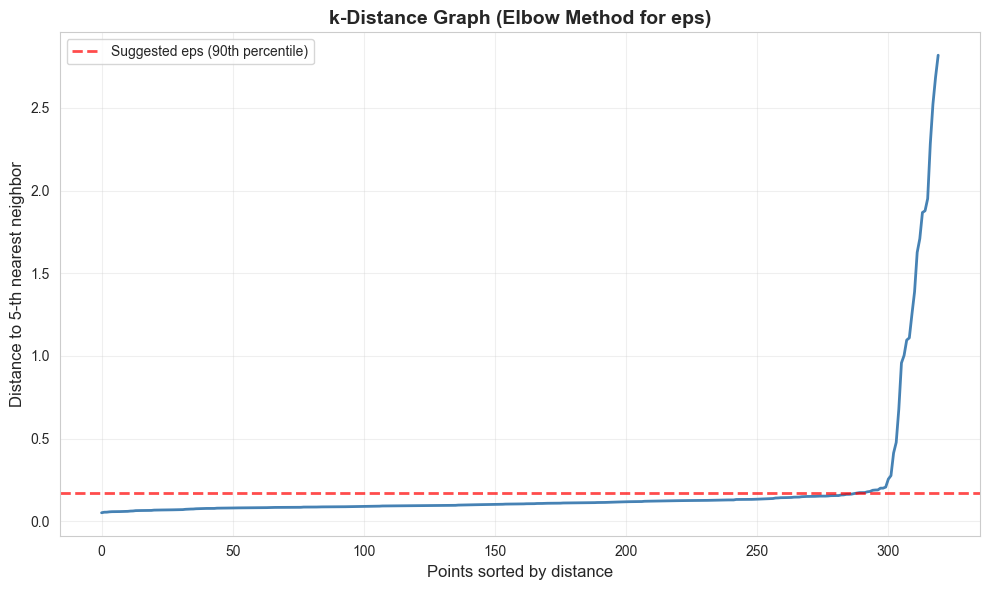

Suggested eps value: 0.1685


In [4]:
def plot_k_distance(X, k=5):
    """
    Plot k-distance graph to help determine optimal eps

    Parameters:
    X: data points
    k: number of neighbors (typically set to min_samples)
    """
    # Calculate distances to k-th nearest neighbor
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors.fit(X)
    distances, indices = neighbors.kneighbors(X)

    # Sort distances
    distances = np.sort(distances[:, k-1], axis=0)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(distances, linewidth=2, color='steelblue')
    ax.set_xlabel('Points sorted by distance', fontsize=12)
    ax.set_ylabel(f'Distance to {k}-th nearest neighbor', fontsize=12)
    ax.set_title('k-Distance Graph (Elbow Method for eps)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Add annotation
    ax.axhline(y=np.percentile(distances, 90), color='red',
              linestyle='--', linewidth=2, alpha=0.7,
              label='Suggested eps (90th percentile)')
    ax.legend()

    plt.tight_layout()
    plt.show()

    suggested_eps = np.percentile(distances, 90)
    print(f"Suggested eps value: {suggested_eps:.4f}")
    return suggested_eps

# Use the function
suggested_eps = plot_k_distance(X_scaled, k=5)

Method 2: Parameter Grid Search


In [5]:
# Test multiple parameter combinations
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = [3, 5, 10, 15]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan_temp = DBSCAN(eps=eps, min_samples=min_samples)
        labels_temp = dbscan_temp.fit_predict(X_scaled)

        n_clusters_temp = len(set(labels_temp)) - (1 if -1 in labels_temp else 0)
        n_noise_temp = list(labels_temp).count(-1)

        # Calculate silhouette score (only if we have clusters)
        if n_clusters_temp > 1 and n_noise_temp < len(labels_temp):
            # Remove noise points for silhouette calculation
            mask = labels_temp != -1
            if sum(mask) > 0:
                silhouette = silhouette_score(X_scaled[mask], labels_temp[mask])
            else:
                silhouette = -1
        else:
            silhouette = -1

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters_temp,
            'n_noise': n_noise_temp,
            'noise_ratio': n_noise_temp / len(labels_temp),
            'silhouette': silhouette
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Find best parameters (highest silhouette score)
best_params = results_df.loc[results_df['silhouette'].idxmax()]

print("\nParameter Search Results:")
print(f"Best parameters:")
print(f"  eps: {best_params['eps']:.2f}")
print(f"  min_samples: {int(best_params['min_samples'])}")
print(f"  Silhouette Score: {best_params['silhouette']:.3f}")
print(f"  Number of clusters: {int(best_params['n_clusters'])}")
print(f"  Noise ratio: {best_params['noise_ratio']:.2%}")


Parameter Search Results:
Best parameters:
  eps: 0.70
  min_samples: 3
  Silhouette Score: 0.646
  Number of clusters: 2
  Noise ratio: 3.75%


Visualize Parameter Search


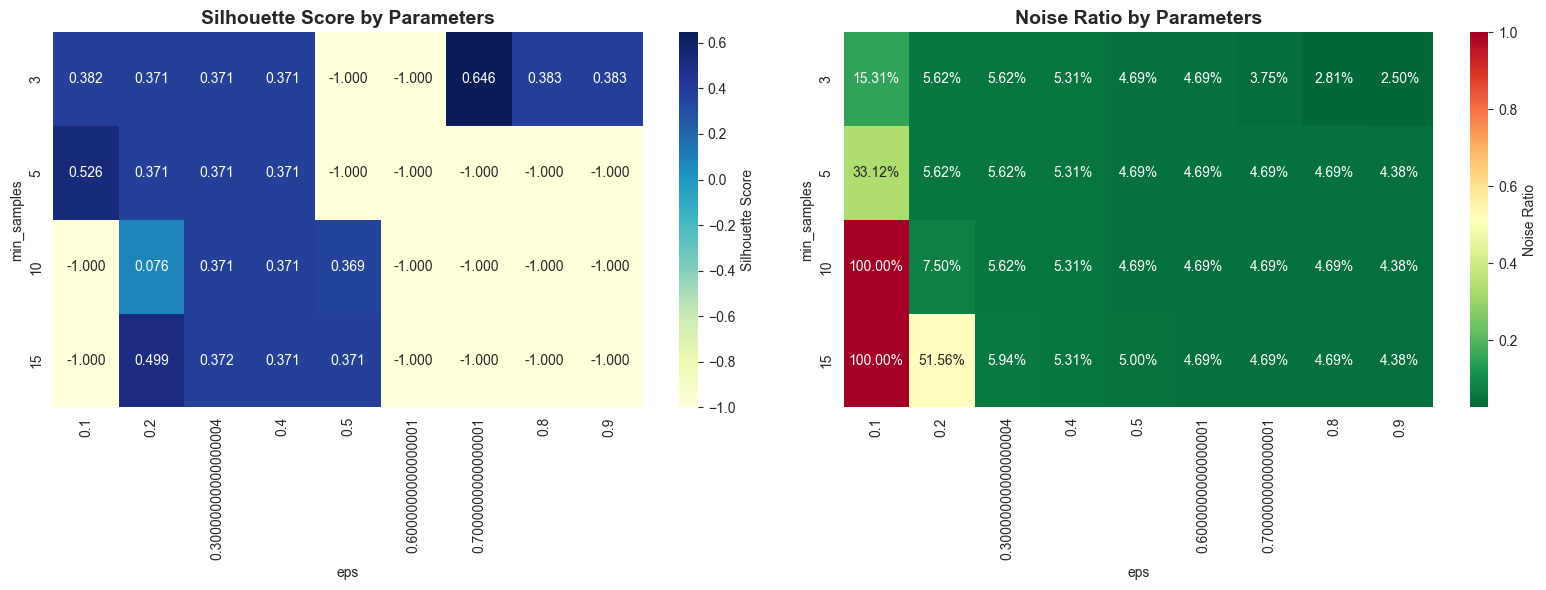

In [6]:
# Create heatmap of results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pivot for heatmaps
silhouette_pivot = results_df.pivot(index='min_samples', columns='eps', values='silhouette')
noise_pivot = results_df.pivot(index='min_samples', columns='eps', values='noise_ratio')

# Plot 1: Silhouette scores
sns.heatmap(silhouette_pivot, annot=True, fmt='.3f', cmap='YlGnBu',
            ax=axes[0], cbar_kws={'label': 'Silhouette Score'})
axes[0].set_title('Silhouette Score by Parameters', fontsize=14, fontweight='bold')
axes[0].set_xlabel('eps')
axes[0].set_ylabel('min_samples')

# Plot 2: Noise ratios
sns.heatmap(noise_pivot, annot=True, fmt='.2%', cmap='RdYlGn_r',
            ax=axes[1], cbar_kws={'label': 'Noise Ratio'})
axes[1].set_title('Noise Ratio by Parameters', fontsize=14, fontweight='bold')
axes[1].set_xlabel('eps')
axes[1].set_ylabel('min_samples')

plt.tight_layout()
plt.show()

# DBSCAN for Anomaly Detection
DBSCAN's noise points are natural candidates for anomalies. Let's see it in action.
- Example: Network Traffic Anomaly Detection

In [7]:
# Simulate network traffic data
np.random.seed(42)

# Normal traffic patterns
normal_traffic = pd.DataFrame({
    'packet_size': np.concatenate([
        np.random.normal(500, 50, 200),   # Web traffic
        np.random.normal(1500, 100, 150), # Video streaming
        np.random.normal(200, 30, 150)    # IoT devices
    ]),
    'packets_per_second': np.concatenate([
        np.random.normal(10, 2, 200),
        np.random.normal(50, 10, 150),
        np.random.normal(5, 1, 150)
    ]),
    'duration': np.concatenate([
        np.random.exponential(10, 200),
        np.random.exponential(60, 150),
        np.random.exponential(5, 150)
    ]),
    'label': 'normal'
})

# Anomalous traffic (DDoS, port scans, data exfiltration)
anomaly_traffic = pd.DataFrame({
    'packet_size': np.concatenate([
        np.random.uniform(50, 100, 15),    # Port scans
        np.random.uniform(2000, 5000, 15), # Data exfiltration
        np.random.uniform(100, 200, 10)    # DDoS
    ]),
    'packets_per_second': np.concatenate([
        np.random.uniform(100, 500, 15),   # Port scans
        np.random.uniform(80, 150, 15),    # Data exfiltration
        np.random.uniform(500, 1000, 10)   # DDoS
    ]),
    'duration': np.concatenate([
        np.random.uniform(0.1, 1, 15),
        np.random.uniform(100, 200, 15),
        np.random.uniform(0.1, 0.5, 10)
    ]),
    'label': 'anomaly'
})

# Combine data
network_df = pd.concat([normal_traffic, anomaly_traffic], ignore_index=True)
network_df = network_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total connections: {len(network_df)}")
print(f"Normal: {sum(network_df['label'] == 'normal')}")
print(f"Anomalies: {sum(network_df['label'] == 'anomaly')}")

Total connections: 540
Normal: 500
Anomalies: 40


Apply DBSCAN for Detection


In [8]:
# Prepare features
X_network = network_df[['packet_size', 'packets_per_second', 'duration']].values
y_true = (network_df['label'] == 'anomaly').astype(int).values

# Scale features
scaler_network = StandardScaler()
X_network_scaled = scaler_network.fit_transform(X_network)

# Apply DBSCAN
dbscan_network = DBSCAN(eps=0.5, min_samples=10)
network_labels = dbscan_network.fit_predict(X_network_scaled)

# Noise points are anomalies
detected_anomalies = (network_labels == -1).astype(int)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

print("\n" + "="*60)
print("NETWORK ANOMALY DETECTION RESULTS")
print("="*60)

print("\nClassification Report:")
print(classification_report(y_true, detected_anomalies,
                          target_names=['Normal', 'Anomaly']))

# Confusion Matrix
cm = confusion_matrix(y_true, detected_anomalies)
print("\nConfusion Matrix:")
print(f"True Negatives:  {cm[0,0]:4d} | False Positives: {cm[0,1]:4d}")
print(f"False Negatives: {cm[1,0]:4d} | True Positives:  {cm[1,1]:4d}")

# Additional metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_true, detected_anomalies, average='binary')
print(f"\nPrecision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")


NETWORK ANOMALY DETECTION RESULTS

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99       500
     Anomaly       0.75      1.00      0.86        40

    accuracy                           0.98       540
   macro avg       0.88      0.99      0.92       540
weighted avg       0.98      0.98      0.98       540


Confusion Matrix:
True Negatives:   487 | False Positives:   13
False Negatives:    0 | True Positives:    40

Precision: 0.755
Recall:    1.000
F1-Score:  0.860


Visualize Network Anomaly Detection


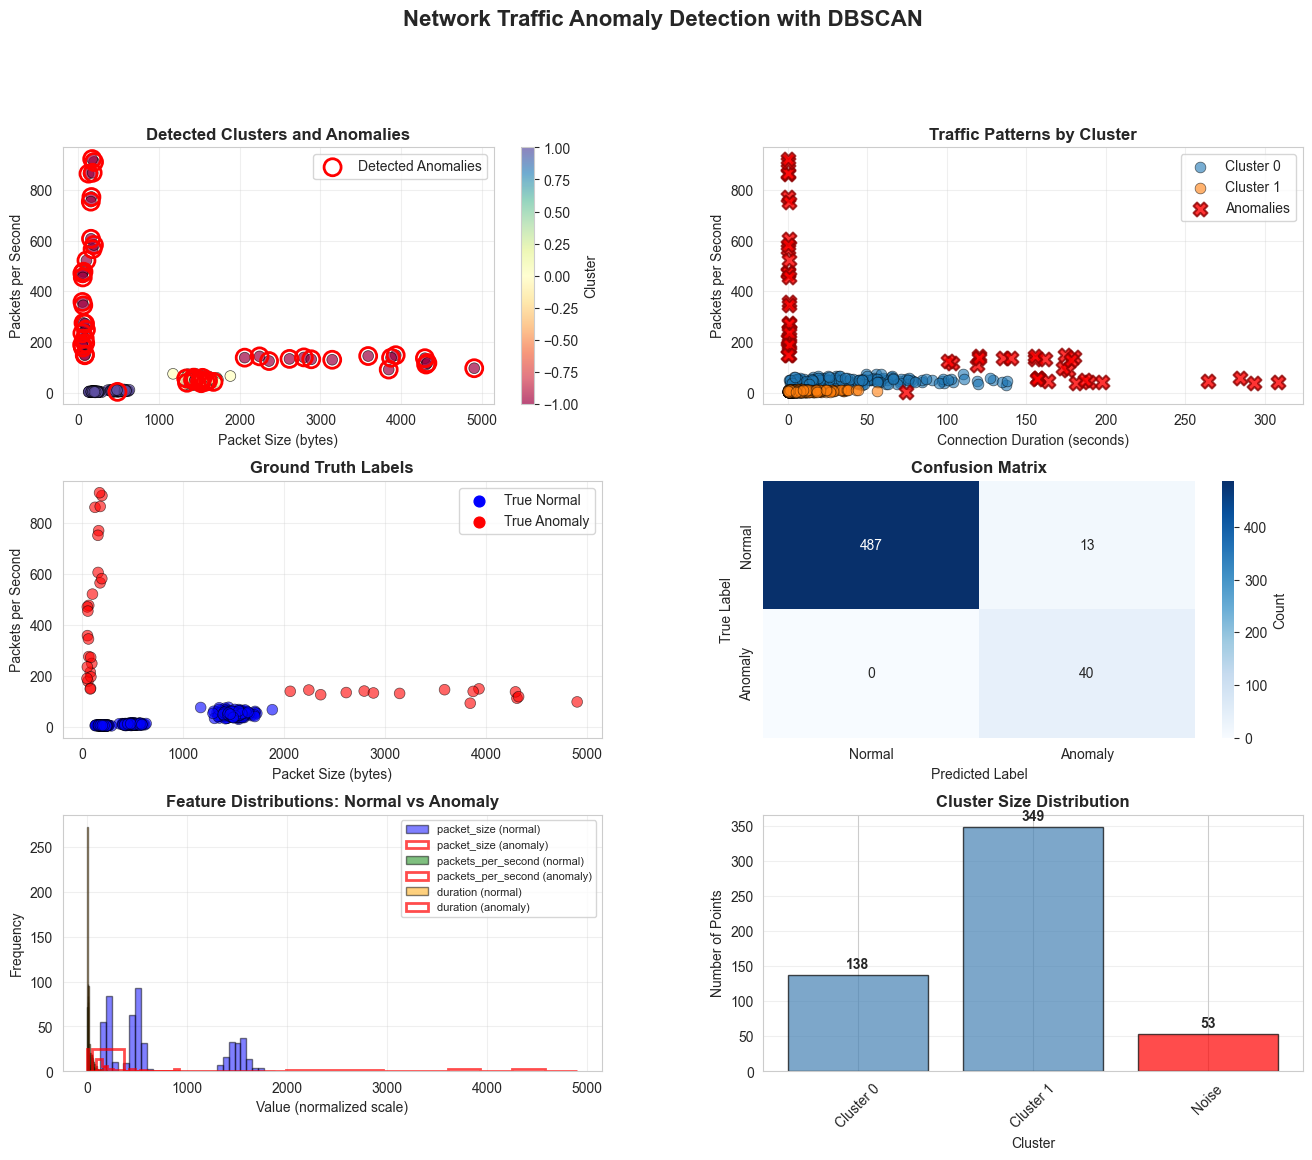


Cluster Statistics:
  Cluster  Count  Avg Packet Size  Avg Packets/sec
Cluster 0    138      1506.175003        50.446848
Cluster 1    349       370.225773         7.869994
    Noise     53      1364.857602       266.318371


In [10]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Packet Size vs Packets/sec
ax1 = fig.add_subplot(gs[0, 0])
scatter1 = ax1.scatter(network_df['packet_size'],
                      network_df['packets_per_second'],
                      c=network_labels, cmap='Spectral', s=60,
                      alpha=0.7, edgecolors='k', linewidths=0.5)
# Highlight detected anomalies
anomaly_mask = network_labels == -1
ax1.scatter(network_df.loc[anomaly_mask, 'packet_size'],
           network_df.loc[anomaly_mask, 'packets_per_second'],
           facecolors='none', edgecolors='red', s=150,
           linewidths=2, label='Detected Anomalies')
ax1.set_xlabel('Packet Size (bytes)')
ax1.set_ylabel('Packets per Second')
ax1.set_title('Detected Clusters and Anomalies', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# 2. Duration vs Packets/sec
ax2 = fig.add_subplot(gs[0, 1])
for label in set(network_labels):
    if label == -1:
        mask = network_labels == label
        ax2.scatter(network_df.loc[mask, 'duration'],
                   network_df.loc[mask, 'packets_per_second'],
                   c='red', s=100, marker='X', alpha=0.8,
                   edgecolors='darkred', linewidths=1.5,
                   label='Anomalies')
    else:
        mask = network_labels == label
        ax2.scatter(network_df.loc[mask, 'duration'],
                   network_df.loc[mask, 'packets_per_second'],
                   s=60, alpha=0.6, edgecolors='k', linewidths=0.5,
                   label=f'Cluster {label}')
ax2.set_xlabel('Connection Duration (seconds)')
ax2.set_ylabel('Packets per Second')
ax2.set_title('Traffic Patterns by Cluster', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Ground truth comparison
ax3 = fig.add_subplot(gs[1, 0])
colors_true = ['blue' if x == 'normal' else 'red' for x in network_df['label']]
ax3.scatter(network_df['packet_size'], network_df['packets_per_second'],
           c=colors_true, s=60, alpha=0.6, edgecolors='k', linewidths=0.5)
ax3.scatter([], [], c='blue', label='True Normal', s=60)
ax3.scatter([], [], c='red', label='True Anomaly', s=60)
ax3.set_xlabel('Packet Size (bytes)')
ax3.set_ylabel('Packets per Second')
ax3.set_title('Ground Truth Labels', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrix Heatmap
ax4 = fig.add_subplot(gs[1, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            cbar_kws={'label': 'Count'})
ax4.set_ylabel('True Label')
ax4.set_xlabel('Predicted Label')
ax4.set_title('Confusion Matrix', fontweight='bold')

# 5. Feature distributions
ax5 = fig.add_subplot(gs[2, 0])
for feature, color in zip(['packet_size', 'packets_per_second', 'duration'],
                          ['blue', 'green', 'orange']):
    normal_vals = network_df[network_df['label'] == 'normal'][feature]
    anomaly_vals = network_df[network_df['label'] == 'anomaly'][feature]

    ax5.hist(normal_vals, bins=30, alpha=0.5, label=f'{feature} (normal)',
            color=color, edgecolor='black')
    ax5.hist(anomaly_vals, bins=15, alpha=0.7, label=f'{feature} (anomaly)',
            color=color, edgecolor='red', histtype='step', linewidth=2)

ax5.set_xlabel('Value (normalized scale)')
ax5.set_ylabel('Frequency')
ax5.set_title('Feature Distributions: Normal vs Anomaly', fontweight='bold')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Cluster statistics
ax6 = fig.add_subplot(gs[2, 1])
cluster_stats = []
for label in set(network_labels):
    mask = network_labels == label
    cluster_stats.append({
        'Cluster': 'Noise' if label == -1 else f'Cluster {label}',
        'Count': sum(mask),
        'Avg Packet Size': network_df.loc[mask, 'packet_size'].mean(),
        'Avg Packets/sec': network_df.loc[mask, 'packets_per_second'].mean()
    })

stats_df = pd.DataFrame(cluster_stats)
x_pos = np.arange(len(stats_df))

ax6.bar(x_pos, stats_df['Count'], alpha=0.7, edgecolor='black',
       color=['red' if 'Noise' in c else 'steelblue' for c in stats_df['Cluster']])
ax6.set_xlabel('Cluster')
ax6.set_ylabel('Number of Points')
ax6.set_title('Cluster Size Distribution', fontweight='bold')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(stats_df['Cluster'], rotation=45)
ax6.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, (idx, row) in enumerate(stats_df.iterrows()):
    ax6.text(i, row['Count'] + 5, str(row['Count']),
            ha='center', va='bottom', fontweight='bold')

plt.suptitle('Network Traffic Anomaly Detection with DBSCAN',
            fontsize=16, fontweight='bold', y=0.995)
plt.show()

print(f"\nCluster Statistics:")
print(stats_df.to_string(index=False))

# Comparing Different Datasets
DBSCAN's strength is handling various cluster shapes. Let's demonstrate:

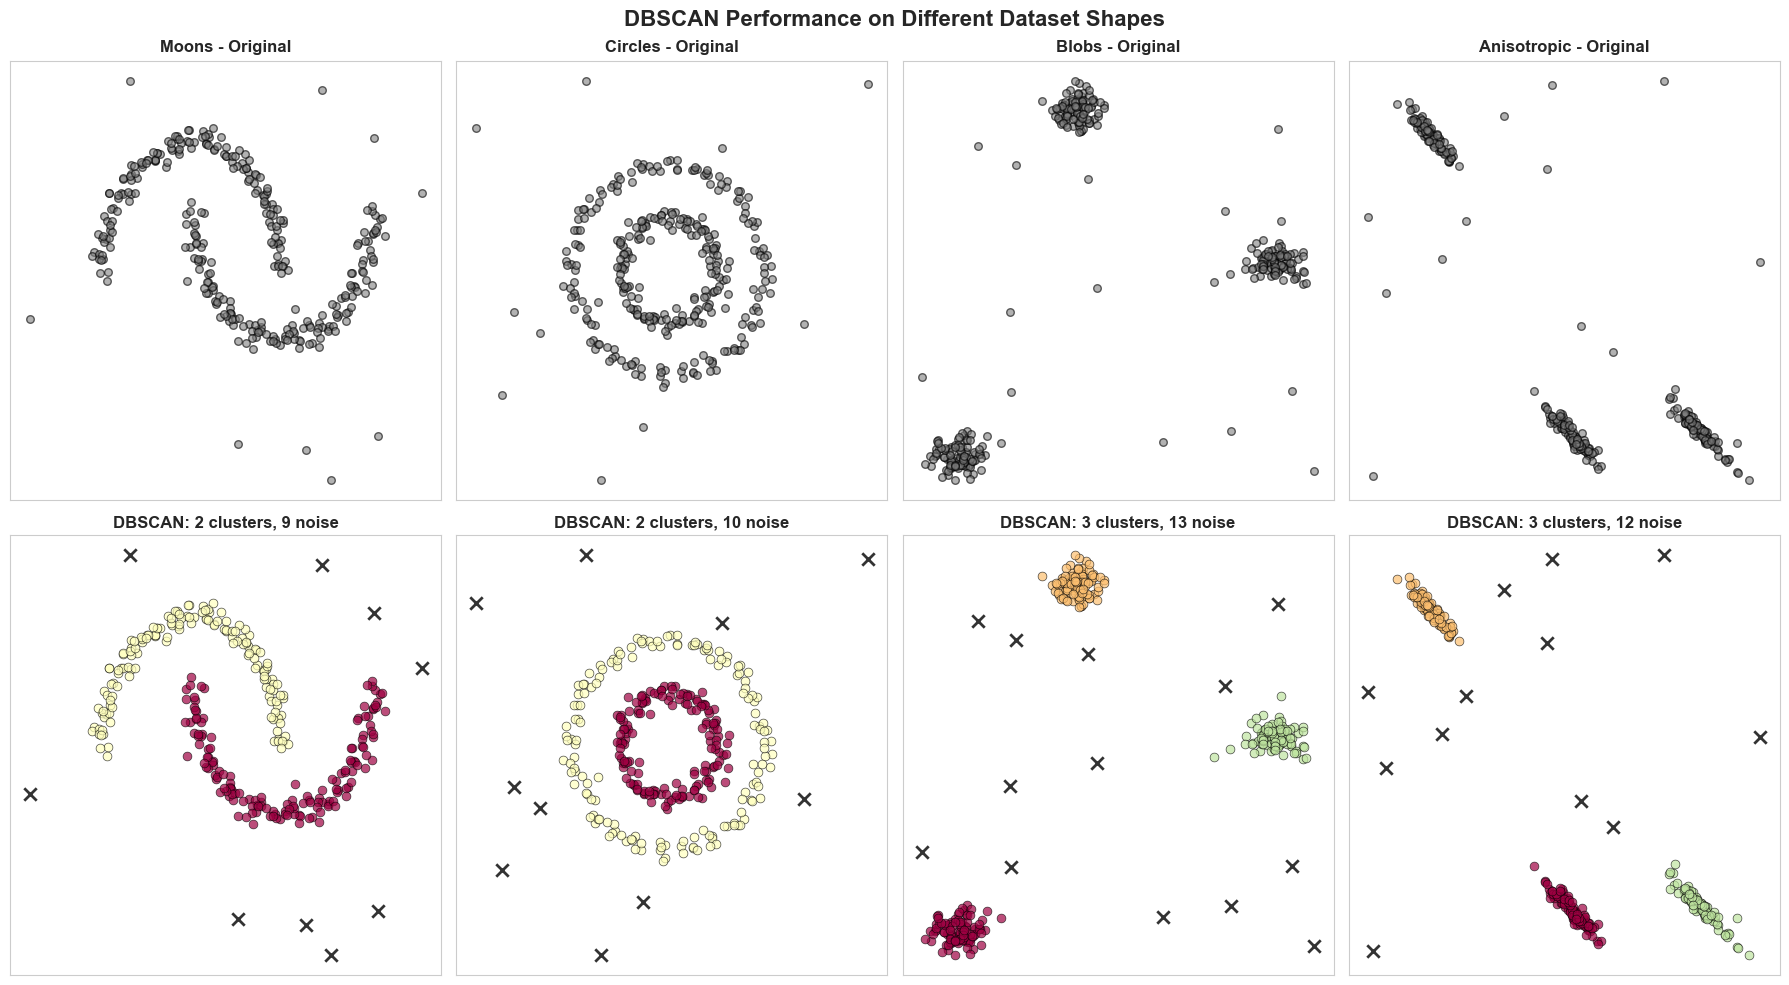

In [11]:
# Create different dataset types
datasets = {
    'Moons': make_moons(n_samples=300, noise=0.05, random_state=42)[0],
    'Circles': make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)[0],
    'Blobs': make_blobs(n_samples=300, centers=3, cluster_std=0.5, random_state=42)[0],
    'Anisotropic': make_blobs(n_samples=300, centers=3, cluster_std=0.5, random_state=42)[0]
}

# Transform anisotropic dataset
transformation = [[0.6, -0.6], [-0.4, 0.8]]
datasets['Anisotropic'] = np.dot(datasets['Anisotropic'], transformation)

# Add outliers to each dataset
for name in datasets:
    outliers = np.random.uniform(
        low=datasets[name].min(axis=0) - 1,
        high=datasets[name].max(axis=0) + 1,
        size=(15, 2)
    )
    datasets[name] = np.vstack([datasets[name], outliers])

# Apply DBSCAN to each dataset
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

for idx, (name, X_data) in enumerate(datasets.items()):
    # Scale data
    X_scaled = StandardScaler().fit_transform(X_data)

    # Original data
    ax_orig = axes[0, idx]
    ax_orig.scatter(X_data[:, 0], X_data[:, 1], c='gray', s=30, alpha=0.6, edgecolors='k')
    ax_orig.set_title(f'{name} - Original', fontweight='bold')
    ax_orig.set_xticks([])
    ax_orig.set_yticks([])

    # DBSCAN clustering
    dbscan_temp = DBSCAN(eps=0.3, min_samples=5)
    labels_temp = dbscan_temp.fit_predict(X_scaled)

    ax_clust = axes[1, idx]
    unique_labels = set(labels_temp)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        if label == -1:
            color = 'black'
            marker = 'x'
            size = 80
            alpha = 0.8
        else:
            marker = 'o'
            size = 40
            alpha = 0.7

        class_mask = (labels_temp == label)
        ax_clust.scatter(X_data[class_mask, 0], X_data[class_mask, 1],
                        c=[color], s=size, alpha=alpha, marker=marker,
                        edgecolors='k' if label != -1 else None,
                        linewidths=0.5 if label != -1 else 2)

    n_clusters = len(set(labels_temp)) - (1 if -1 in labels_temp else 0)
    n_noise = list(labels_temp).count(-1)
    ax_clust.set_title(f'DBSCAN: {n_clusters} clusters, {n_noise} noise', fontweight='bold')
    ax_clust.set_xticks([])
    ax_clust.set_yticks([])

plt.suptitle('DBSCAN Performance on Different Dataset Shapes',
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Real-World Application: Customer Segmentation with Fraud Detection


In [12]:
# Generate customer transaction data
np.random.seed(42)
n_customers = 500

# Normal customer segments
segment1 = pd.DataFrame({  # Budget shoppers
    'avg_purchase': np.random.gamma(2, 15, 150),
    'purchase_frequency': np.random.normal(5, 2, 150),
    'account_age_days': np.random.normal(365, 100, 150),
    'segment': 'budget'
})

segment2 = pd.DataFrame({  # Regular shoppers
    'avg_purchase': np.random.gamma(3, 40, 200),
    'purchase_frequency': np.random.normal(15, 5, 200),
    'account_age_days': np.random.normal(500, 150, 200),
    'segment': 'regular'
})

segment3 = pd.DataFrame({  # Premium shoppers
    'avg_purchase': np.random.gamma(5, 100, 100),
    'purchase_frequency': np.random.normal(25, 8, 100),
    'account_age_days': np.random.normal(800, 200, 100),
    'segment': 'premium'
})

# Fraudulent accounts
fraud = pd.DataFrame({
    'avg_purchase': np.random.uniform(1000, 5000, 50),  # Unusually high
    'purchase_frequency': np.random.uniform(50, 100, 50),  # Very frequent
    'account_age_days': np.random.uniform(1, 30, 50),  # Very new accounts
    'segment': 'fraud'
})

# Combine all data
customer_df = pd.concat([segment1, segment2, segment3, fraud], ignore_index=True)
customer_df = customer_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Customer Distribution:")
print(customer_df['segment'].value_counts())

Customer Distribution:
segment
regular    200
budget     150
premium    100
fraud       50
Name: count, dtype: int64


In [13]:
# Prepare features
X_customers = customer_df[['avg_purchase', 'purchase_frequency', 'account_age_days']].values
y_true_fraud = (customer_df['segment'] == 'fraud').astype(int).values

# Scale features
scaler_customers = StandardScaler()
X_customers_scaled = scaler_customers.fit_transform(X_customers)

# Apply DBSCAN
dbscan_customers = DBSCAN(eps=0.5, min_samples=15)
customer_labels = dbscan_customers.fit_predict(X_customers_scaled)

# Identify fraud as noise points
fraud_detected = (customer_labels == -1).astype(int)

# Results
n_segments = len(set(customer_labels)) - (1 if -1 in customer_labels else 0)
n_fraud_detected = sum(fraud_detected)

print(f"\nSegmentation Results:")
print(f"Customer segments identified: {n_segments}")
print(f"Potential fraud cases detected: {n_fraud_detected}")
print(f"Actual fraud cases: {sum(y_true_fraud)}")

# Evaluation
print("\nFraud Detection Performance:")
print(classification_report(y_true_fraud, fraud_detected,
                          target_names=['Legitimate', 'Fraud']))


Segmentation Results:
Customer segments identified: 1
Potential fraud cases detected: 62
Actual fraud cases: 50

Fraud Detection Performance:
              precision    recall  f1-score   support

  Legitimate       1.00      0.97      0.99       450
       Fraud       0.81      1.00      0.89        50

    accuracy                           0.98       500
   macro avg       0.90      0.99      0.94       500
weighted avg       0.98      0.98      0.98       500



/var/folders/50/kmf0fqmd2sv_hvt0nxtxgt_00000gp/T/ipykernel_71419/771986212.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


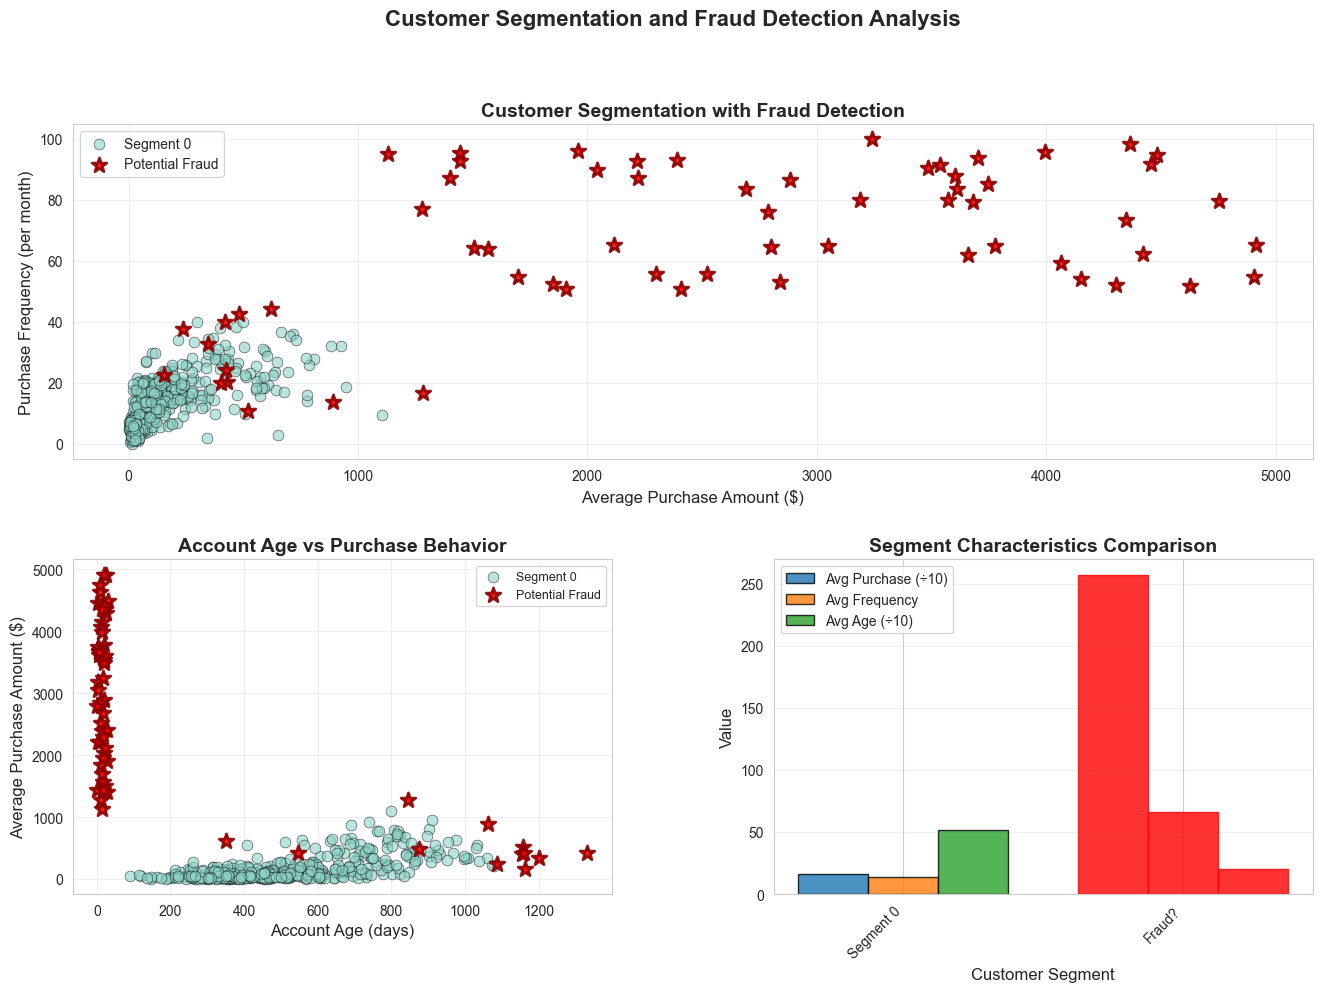


CUSTOMER SEGMENT ANALYSIS
  Segment  Count  Avg Purchase  Avg Frequency    Avg Age
Segment 0    438    163.870973      13.661359 513.369683
   Fraud?     62   2569.272227      66.171914 204.060475

Segment Details:

Segment 0:
  Customers: 438
  Average Purchase: $163.87
  Purchase Frequency: 13.7 times/month
  Average Account Age: 513 days

Fraud?:
  Customers: 62
  Average Purchase: $2569.27
  Purchase Frequency: 66.2 times/month
  Average Account Age: 204 days


In [15]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. 3D scatter plot (using 2D projection)
ax1 = fig.add_subplot(gs[0, :])

unique_labels_cust = set(customer_labels)
colors_cust = plt.cm.Set3(np.linspace(0, 1, len(unique_labels_cust)))

for label, color in zip(unique_labels_cust, colors_cust):
    if label == -1:
        mask = customer_labels == label
        ax1.scatter(customer_df.loc[mask, 'avg_purchase'],
                   customer_df.loc[mask, 'purchase_frequency'],
                   c='red', s=120, marker='*', alpha=0.9,
                   edgecolors='darkred', linewidths=2,
                   label='Potential Fraud', zorder=10)
    else:
        mask = customer_labels == label
        ax1.scatter(customer_df.loc[mask, 'avg_purchase'],
                   customer_df.loc[mask, 'purchase_frequency'],
                   c=[color], s=60, alpha=0.6, edgecolors='k',
                   linewidths=0.5, label=f'Segment {label}')

ax1.set_xlabel('Average Purchase Amount ($)', fontsize=12)
ax1.set_ylabel('Purchase Frequency (per month)', fontsize=12)
ax1.set_title('Customer Segmentation with Fraud Detection',
             fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Account Age vs Purchase Amount
ax2 = fig.add_subplot(gs[1, 0])

for label in unique_labels_cust:
    if label == -1:
        mask = customer_labels == label
        ax2.scatter(customer_df.loc[mask, 'account_age_days'],
                   customer_df.loc[mask, 'avg_purchase'],
                   c='red', s=120, marker='*', alpha=0.9,
                   edgecolors='darkred', linewidths=2,
                   label='Potential Fraud', zorder=10)
    else:
        mask = customer_labels == label
        color_idx = list(unique_labels_cust).index(label)
        ax2.scatter(customer_df.loc[mask, 'account_age_days'],
                   customer_df.loc[mask, 'avg_purchase'],
                   c=[colors_cust[color_idx]], s=60, alpha=0.6,
                   edgecolors='k', linewidths=0.5, label=f'Segment {label}')

ax2.set_xlabel('Account Age (days)', fontsize=12)
ax2.set_ylabel('Average Purchase Amount ($)', fontsize=12)
ax2.set_title('Account Age vs Purchase Behavior', fontsize=14, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Segment Statistics
ax3 = fig.add_subplot(gs[1, 1])

segment_stats = []
for label in unique_labels_cust:
    mask = customer_labels == label
    segment_stats.append({
        'Segment': 'Fraud?' if label == -1 else f'Segment {label}',
        'Count': sum(mask),
        'Avg Purchase': customer_df.loc[mask, 'avg_purchase'].mean(),
        'Avg Frequency': customer_df.loc[mask, 'purchase_frequency'].mean(),
        'Avg Age': customer_df.loc[mask, 'account_age_days'].mean()
    })

stats_df = pd.DataFrame(segment_stats).sort_values('Count', ascending=False)

# Create grouped bar chart
x_pos = np.arange(len(stats_df))
width = 0.25

bars1 = ax3.bar(x_pos - width, stats_df['Avg Purchase']/10, width,
               label='Avg Purchase (÷10)', alpha=0.8, edgecolor='black')
bars2 = ax3.bar(x_pos, stats_df['Avg Frequency'], width,
               label='Avg Frequency', alpha=0.8, edgecolor='black')
bars3 = ax3.bar(x_pos + width, stats_df['Avg Age']/10, width,
               label='Avg Age (÷10)', alpha=0.8, edgecolor='black')

# Color the fraud segment differently
for i, segment in enumerate(stats_df['Segment']):
    if 'Fraud' in segment:
        bars1[i].set_color('red')
        bars2[i].set_color('red')
        bars3[i].set_color('red')

ax3.set_xlabel('Customer Segment', fontsize=12)
ax3.set_ylabel('Value', fontsize=12)
ax3.set_title('Segment Characteristics Comparison', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(stats_df['Segment'], rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

plt.suptitle('Customer Segmentation and Fraud Detection Analysis',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*70)
print("CUSTOMER SEGMENT ANALYSIS")
print("="*70)
print(stats_df.to_string(index=False))
print("\nSegment Details:")
for _, row in stats_df.iterrows():
    print(f"\n{row['Segment']}:")
    print(f"  Customers: {int(row['Count'])}")
    print(f"  Average Purchase: ${row['Avg Purchase']:.2f}")
    print(f"  Purchase Frequency: {row['Avg Frequency']:.1f} times/month")
    print(f"  Average Account Age: {row['Avg Age']:.0f} days")

# Advanced Techniques
1. Hierarchical DBSCAN (HDBSCAN)
For even better results with varying density clusters, consider HDBSCAN:


/Users/achuth.iyyatil/Code/personal/friendly-fortnight/.venv/lib/python3.12/site-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


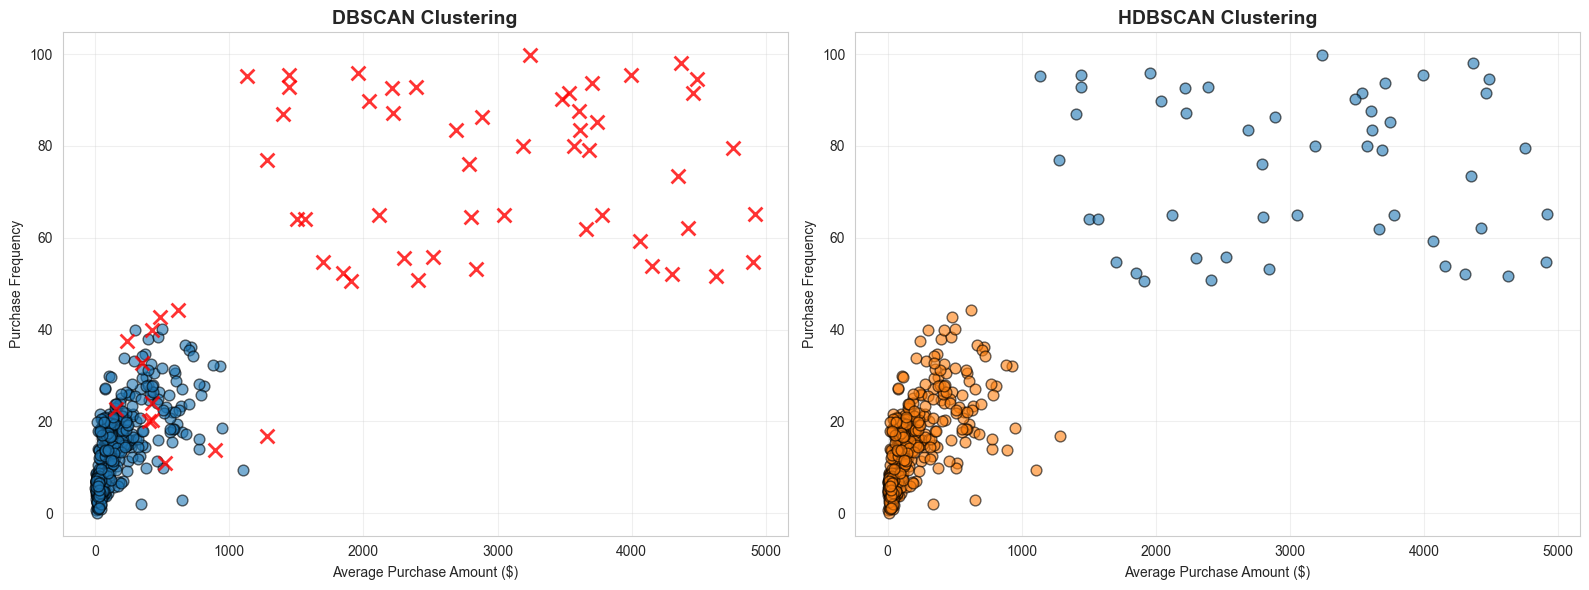


DBSCAN found 1 clusters
HDBSCAN found 1 clusters


In [17]:
# Install: pip install hdbscan
import hdbscan

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5)
hdbscan_labels = clusterer.fit_predict(X_customers_scaled)

# Compare with DBSCAN
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# DBSCAN results
ax1 = axes[0]
for label in set(customer_labels):
    mask = customer_labels == label
    if label == -1:
        ax1.scatter(customer_df.loc[mask, 'avg_purchase'],
                   customer_df.loc[mask, 'purchase_frequency'],
                   c='red', s=100, marker='x', alpha=0.8, linewidths=2)
    else:
        ax1.scatter(customer_df.loc[mask, 'avg_purchase'],
                   customer_df.loc[mask, 'purchase_frequency'],
                   s=60, alpha=0.6, edgecolors='k')
ax1.set_title('DBSCAN Clustering', fontsize=14, fontweight='bold')
ax1.set_xlabel('Average Purchase Amount ($)')
ax1.set_ylabel('Purchase Frequency')
ax1.grid(True, alpha=0.3)

# HDBSCAN results
ax2 = axes[1]
for label in set(hdbscan_labels):
    mask = hdbscan_labels == label
    if label == -1:
        ax2.scatter(customer_df.loc[mask, 'avg_purchase'],
                   customer_df.loc[mask, 'purchase_frequency'],
                   c='red', s=100, marker='x', alpha=0.8, linewidths=2)
    else:
        ax2.scatter(customer_df.loc[mask, 'avg_purchase'],
                   customer_df.loc[mask, 'purchase_frequency'],
                   s=60, alpha=0.6, edgecolors='k')
ax2.set_title('HDBSCAN Clustering', fontsize=14, fontweight='bold')
ax2.set_xlabel('Average Purchase Amount ($)')
ax2.set_ylabel('Purchase Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDBSCAN found {len(set(customer_labels)) - 1} clusters")
print(f"HDBSCAN found {len(set(hdbscan_labels)) - 1} clusters")

2. Feature Engineering for Better Results


In [18]:
# Add derived features
customer_df['value_score'] = customer_df['avg_purchase'] * customer_df['purchase_frequency']
customer_df['account_maturity'] = np.log1p(customer_df['account_age_days'])
customer_df['purchase_intensity'] = customer_df['purchase_frequency'] / (customer_df['account_age_days'] / 30)

# Use enhanced features
X_enhanced = customer_df[['avg_purchase', 'purchase_frequency',
                         'account_age_days', 'value_score',
                         'account_maturity', 'purchase_intensity']].values

X_enhanced_scaled = StandardScaler().fit_transform(X_enhanced)

# Apply DBSCAN with enhanced features
dbscan_enhanced = DBSCAN(eps=0.5, min_samples=15)
labels_enhanced = dbscan_enhanced.fit_predict(X_enhanced_scaled)

print(f"\nEnhanced Features Results:")
print(f"Clusters: {len(set(labels_enhanced)) - (1 if -1 in labels_enhanced else 0)}")
print(f"Noise points: {list(labels_enhanced).count(-1)}")


Enhanced Features Results:
Clusters: 1
Noise points: 64


3. Distance Metrics Comparison


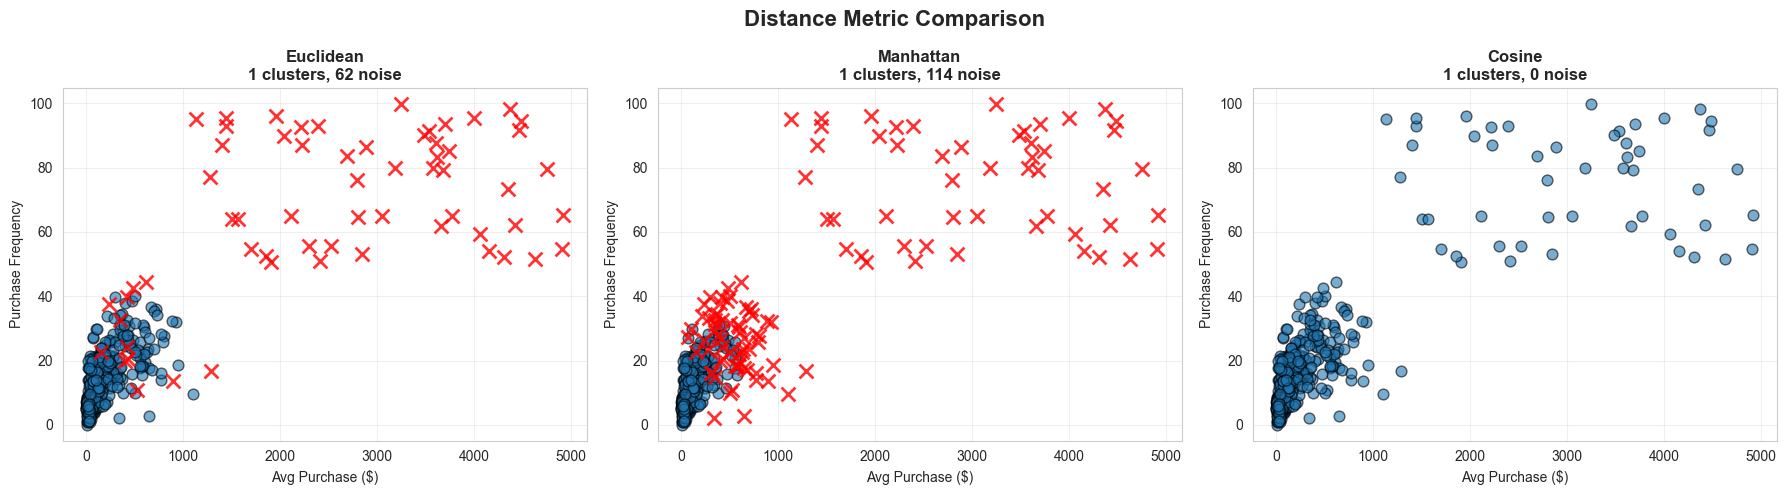


Distance Metric Results:
   metric  n_clusters  n_noise
euclidean           1       62
manhattan           1      114
   cosine           1        0


In [19]:
from sklearn.metrics.pairwise import pairwise_distances

# Test different distance metrics
metrics = ['euclidean', 'manhattan', 'cosine']
results_metrics = []

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    dbscan_metric = DBSCAN(eps=0.5, min_samples=15, metric=metric)
    labels_metric = dbscan_metric.fit_predict(X_customers_scaled)

    n_clusters = len(set(labels_metric)) - (1 if -1 in labels_metric else 0)
    n_noise = list(labels_metric).count(-1)

    results_metrics.append({
        'metric': metric,
        'n_clusters': n_clusters,
        'n_noise': n_noise
    })

    # Plot
    ax = axes[idx]
    for label in set(labels_metric):
        mask = labels_metric == label
        if label == -1:
            ax.scatter(customer_df.loc[mask, 'avg_purchase'],
                      customer_df.loc[mask, 'purchase_frequency'],
                      c='red', s=100, marker='x', alpha=0.8, linewidths=2)
        else:
            ax.scatter(customer_df.loc[mask, 'avg_purchase'],
                      customer_df.loc[mask, 'purchase_frequency'],
                      s=60, alpha=0.6, edgecolors='k')
    ax.set_title(f'{metric.capitalize()}\n{n_clusters} clusters, {n_noise} noise',
                fontweight='bold')
    ax.set_xlabel('Avg Purchase ($)')
    ax.set_ylabel('Purchase Frequency')
    ax.grid(True, alpha=0.3)

plt.suptitle('Distance Metric Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nDistance Metric Results:")
print(pd.DataFrame(results_metrics).to_string(index=False))

# Performance Optimization
For Large Datasets


In [20]:
from sklearn.neighbors import BallTree, KDTree

# Use Ball Tree for faster neighbor search
dbscan_optimized = DBSCAN(
    eps=0.5,
    min_samples=15,
    algorithm='ball_tree',  # Options: 'ball_tree', 'kd_tree', 'brute'
    leaf_size=30,
    n_jobs=-1  # Use all CPU cores
)

import time

start = time.time()
labels_opt = dbscan_optimized.fit_predict(X_customers_scaled)
end = time.time()

print(f"Optimized DBSCAN runtime: {end - start:.3f} seconds")

Optimized DBSCAN runtime: 0.026 seconds



## Best Practices and Tips

### 1. Choosing eps and min_samples

**Rules of Thumb:**
- **min_samples**: Start with `2 × dimensions` (for 2D data, try min_samples=4)
- **eps**: Use k-distance graph or domain knowledge
- Higher min_samples = more robust to noise but may split natural clusters

### 2. When to Use DBSCAN

**✅ Good For:**
- Arbitrary cluster shapes (non-spherical)
- Clusters with varying densities
- Automatic outlier detection needed
- Unknown number of clusters
- Spatial data (geographic, image segmentation)

**❌ Not Ideal For:**
- Very high-dimensional data (>20 features)
- Clusters with vastly different densities
- When all points must be assigned to clusters
- Real-time applications on very large datasets

### 3. Dealing with High Dimensions

```python
from sklearn.decomposition import PCA

# Reduce dimensions before DBSCAN
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_customers_scaled)

print(f"Variance explained: {sum(pca.explained_variance_ratio_):.2%}")

# Apply DBSCAN on reduced data
dbscan_pca = DBSCAN(eps=0.5, min_samples=15)
labels_pca = dbscan_pca.fit_predict(X_pca)
```

### 4. Combining with Other Methods

```python
# Use DBSCAN for outlier removal, then k-means for clustering
from sklearn.cluster import KMeans

# Remove outliers with DBSCAN
dbscan_filter = DBSCAN(eps=0.5, min_samples=15)
labels_filter = dbscan_filter.fit_predict(X_customers_scaled)

# Keep only non-outlier points
X_filtered = X_customers_scaled[labels_filter != -1]

# Apply k-means on clean data
kmeans = KMeans(n_clusters=3, random_state=42)
final_labels = kmeans.fit_predict(X_filtered)

print(f"Removed {sum(labels_filter == -1)} outliers")
print(f"Clustered {len(X_filtered)} clean points into 3 segments")
```

## Practical Checklist

Before applying DBSCAN:

- [ ] Scale your features (StandardScaler, RobustScaler)
- [ ] Check for high dimensionality (consider PCA if >20 features)
- [ ] Use k-distance graph to estimate eps
- [ ] Start with min_samples = 2 × dimensions
- [ ] Validate on a sample before processing full dataset
- [ ] Compare with other algorithms (k-means, hierarchical)
- [ ] Interpret noise points in domain context

## Conclusion

DBSCAN is a powerful clustering algorithm that excels at:
- **Finding complex cluster shapes** that k-means misses
- **Automatic outlier detection** built into the algorithm
- **No need to specify cluster count** in advance
- **Robust handling** of noise and irregularities

**Key Takeaways:**
- Parameter selection is crucial (use k-distance graph)
- Works best with 2-20 dimensions
- Noise points are valuable for anomaly detection
- Combine with other techniques for best results
- Always scale your features first!